In [1]:
#Store all files data array
import glob
import errno
import spacy
nlp = spacy.load('en')

path = 'cases2/*.txt'
names = glob.glob(path)
data = []
filenames = []
for name in names:
    try:
        with open(name) as f:
            data.append(f.read())
            filenames.append(name)
    except IOError as exc:
        if exc.errno != errno.EISDIR:
            raise
            
number_of_files = len(filenames)

In [2]:
#Split the file into sentences
sentences = []
for d in data:
    temp = nlp(d)
    sents = list(temp.sents)
    sentences.append(sents)

In [3]:
#Split the file into tokens
tokens = []
#fast punctuation removal
from string import punctuation
translator = str.maketrans('','',punctuation) 
for d in data:
    d_lower = d.lower()
    d_nopunc = d_lower.translate(translator)
    #toks = d_nopunc.split()    
    tokens.append(list(nlp(d_nopunc)))

In [4]:
#Drop all numbers in token array
tokens_wo_numbers = []
for toks in tokens:
    toks_wo_numbers = [t for t in toks if not t.is_digit]
    tokens_wo_numbers.append(toks_wo_numbers)
tokens = tokens_wo_numbers

In [5]:
#Count sentences, words and letters
import numpy as np
nums = {}
nums["num_sentences"] = np.zeros(number_of_files)
nums["num_tokens"] = np.zeros(number_of_files)
nums["num_letters"] = np.zeros(number_of_files)

#for sen in sentences:
#    nums["num_sentences"].append(len(sen))

#for toks in tokens:
#    nums["num_tokens"].append(len(toks))

#for d in data:
#    nums["num_letters"].append(len(d))

for i in range(number_of_files):
    nums["num_sentences"][i] = len(sentences[i])
    nums["num_tokens"][i] = len(tokens[i])
    nums["num_letters"][i] = len(data[i])

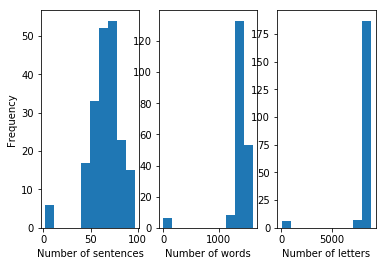

In [24]:
#Draw histograms
import matplotlib.pyplot as plt
#n_bins = 20

plt.subplot(1,3,1)
plt.hist(nums["num_sentences"])
plt.ylabel("Frequency")
plt.xlabel("Number of sentences")

plt.subplot(1,3,2)
plt.hist(nums["num_tokens"])
plt.xlabel("Number of words")

plt.subplot(1,3,3)
plt.hist(nums["num_letters"])
plt.xlabel("Number of letters")

plt.show()

In [7]:
#Count POS words
from collections import Counter
nums["freq_nouns"] = []
nums["freq_verbs"] = []
nums["freq_adj"] = []
nums["num_nouns"] = []
nums["num_verbs"] = []
nums["num_adj"] = []

i=0
for d in data:
    n_words = nums["num_tokens"][i]
    c = Counter(([token.pos_ for token in nlp(d)]))
    nums["num_nouns"].append(c["NOUN"])
    nums["num_verbs"].append(c["VERB"])
    nums["num_adj"].append(c["ADJ"])
    nums["freq_nouns"].append(c["NOUN"]/n_words)
    nums["freq_verbs"].append(c["VERB"]/n_words)
    nums["freq_adj"].append(c["ADJ"]/n_words)
    i += 1

Text(0, 0.5, 'adjectives')

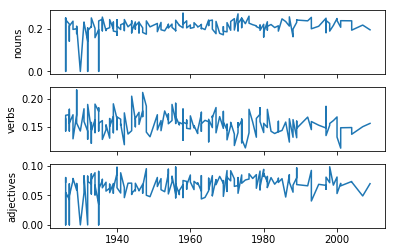

In [8]:
#Plot pos-frequencies per year
year = []
file_id = []

for name in filenames:
    yr = name.split("/")[1].split("_")[0]
    f_id = name.split("/")[1].split("_")[1].split(".")[0]
    year.append(int(yr))
    file_id.append(f_id)

ax1 = plt.subplot(311)
plt.plot(year, nums["freq_nouns"])
plt.ylabel("nouns")
plt.setp(ax1.get_xticklabels(), visible=False)
ax2 = plt.subplot(312, sharex=ax1)
plt.plot(year, nums["freq_verbs"])
plt.ylabel("verbs")
plt.setp(ax2.get_xticklabels(), visible=False)
plt.subplot(313, sharex=ax1)
plt.plot(year, nums["freq_adj"])
plt.ylabel("adjectives")

In [9]:
#Normalization of corpus
#already removed punctuation and numbers
#now removing stopwords, doing lemmatizing

norm_tokens = []

for tok in tokens:
    tok = [t for t in tok if not t.is_stop]
    tok = [t for t in tok if t.pos_ != "SPACE"] #removing emptry words
    tok = [t.lemma_ for t in tok]
    norm_tokens.append(tok)

In [10]:
#Create trigrams which end with a noun
from nltk import ngrams
#is there a way to do this with spacy???
grams = []

for tok in norm_tokens:
    gram = list(ngrams(tok, 3))
    gram = [g for g in gram if list(nlp(g[2]))[0].pos_ == "NOUN"]
    grams += gram

all_grams = Counter(grams)
print(all_grams.most_common()[:5])  # most frequent n-grams

mc = all_grams.most_common()[:1000]
most_common_grams = [gram[0] for gram in mc] #store 1000 frequently used grams as tuples

[(('v', 'united', 'state'), 186), (('united', 'state', 'sct'), 70), (('judgment', 'district', 'court'), 45), (('deny', 'sct', 'led2d'), 44), (('united', 'state', 'district'), 43)]


In [11]:
#Create dataframe for frequencies over trigrams
import pandas as pd

counter_list = []
nums["num_grams"] = []

for tok in norm_tokens:
    gram = list(ngrams(tok, 3))
    gram = [g for g in gram if list(nlp(g[2]))[0].pos_ == "NOUN"]
    nums["num_grams"].append(len(gram))
    counter = Counter(gram)
    counter_list.append(counter)

#Divide each row by number of trigrams
def standardize_rows(row):
    return row / nums["num_grams"]

#df = pd.DataFrame(columns=most_common_grams) #use only the most common 1000 trigrams
#df = df.append(counter_list, sort=False)
#df = df[most_common_grams]
df = pd.DataFrame(counter_list) #use all trigrams
df = df[most_common_grams]      #reduce to most common 1000 trigrams
df = df.apply(standardize_rows)
df.fillna(0,inplace=True)
df.head()

(v, united, state)  (united, state, sct)  (judgment, district, court)  \
0                 0.0                   0.0                          0.0   
1                 0.0                   0.0                          0.0   
2                 0.0                   0.0                          0.0   
3                 0.0                   0.0                          0.0   
4                 0.0                   0.0                          0.0   

   (deny, sct, led2d)  (united, state, district)  (state, district, court)  \
0                 0.0                        0.0                       0.0   
1                 0.0                        0.0                       0.0   
2                 0.0                        0.0                       0.0   
3                 0.0                        0.0                       0.0   
4                 0.0                        0.0                       0.0   

   (cert, deny, sct)  (circuit, judge, appeal)  (united, state, attorney)  \
0                0.0                  0.000000                   0.000000   
1                0.0                  0.000000                   0.004902   
2                0.0                  0.000000                   0.000000   
3                0.0                  0.002198                   0.000000   
4                0.0                  0.002532                   0.000000   

   (interstate, commerce, commission)             ...               \
0                                 0.0             ...                
1                                 0.0             ...                
2                                 0.0             ...                
3                                 0.0             ...                
4                                 0.0             ...                

   (right, attorney, fee)  (fee, award, act)  (usc, district, court)  \
0                     0.0                0.0                     0.0   
1                     0.0                0.0                     0.0   
2                     0.0                0.0                     0.0   
3                     0.0                0.0                     0.0   
4                     0.0                0.0                     0.0   

   (f2d, 2d, cir1983)  (contractual, relationship, party)  \
0                 0.0                                 0.0   
1                 0.0                                 0.0   
2                 0.0                                 0.0   
3                 0.0                                 0.0   
4                 0.0                                 0.0   

   (stagger, rail, act)  (totally, intrastate, motor)  (affect, power, state)  \
0                   0.0                           0.0                     0.0   
1                   0.0                           0.0                     0.0   
2                   0.0                           0.0                     0.0   
3                   0.0                           0.0                     0.0   
4                   0.0                           0.0                     0.0   

   (regulate, intrastate, transportation)  (rail, carrier, regulation)  
0                                     0.0                          0.0  
1                                     0.0                          0.0  
2                                     0.0                          0.0  
3                                     0.0                          0.0  
4                                     0.0                          0.0  

[5 rows x 1000 columns]

In [12]:
#Link dataframe to outcome reverse
df["caseid"] = file_id

reverse = pd.read_csv('case_reversed.csv')
df = pd.merge(df, reverse, on="caseid")
df.head()

case_reversed = df["case_reversed"].tolist()
df = df.drop(columns=["caseid", "case_reversed"])

In [21]:
#Create training and test set
#Train logistic regression model and calculate accuracy and f1 score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(df, case_reversed, test_size=0.2)

log_reg = LogisticRegression(solver="lbfgs")
log_reg.fit(X_train, y_train)

acc = log_reg.score(X_test, y_test)
f1test = f1_score(y_test, log_reg.predict(X_test))
f1train = f1_score(y_train, log_reg.predict(X_train))

print("Accuracy: ", acc)
print("F1 test-set: ", f1test)
print("F1 train-set: ", f1train)

Accuracy:  0.6
F1 test-set:  0.7499999999999999
F1 train-set:  0.754863813229572


In [22]:
#Find best hyperparameters with GridSearchCV
from sklearn.model_selection import GridSearchCV
import numpy as np

C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=['l1', 'l2'])
logistic = LogisticRegression(solver="liblinear")
gscv = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)
best_model = gscv.fit(X_train, y_train)

print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

print("Accuracy: ", best_model.score(X_test, y_test))
print("F1 with best model: ", f1_score(y_test, best_model.predict(X_test)))

Best Penalty: l1
Best C: 1.0
Accuracy:  0.6
F1 with best model:  0.7499999999999999


/root/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


/root/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


AOC value:  0.5


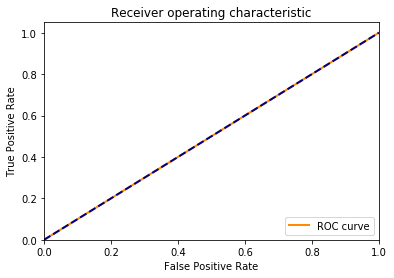

In [23]:
#Plot ROC and AUC
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

y_score = best_model.fit(X_train, y_train).decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

print("AOC value: ", roc_auc)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [16]:
#New dataframe with each sentences as own document
#Compute compound sentiment score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

df2 = pd.DataFrame()
temp_raw = []
#temp_spacy = []
for sen in sentences:
    temp_raw.extend(s.text for s in sen)
    #temp_spacy.extend(sen)
    
df2["doc"] = temp_raw
#df2["sen"] = temp_spacy

def analyze_sen(row):
    ss = sid.polarity_scores(row)
    return ss["compound"]
       
df2["sentiment"] = df2["doc"].apply(analyze_sen)
df2 = df2.sort_values(by=["sentiment"])

print("Top 10 lowest-sentiment sentences:")
print(df2[["doc", "sentiment"]][:10])
print("\nTop 10 highest-sentiment sentences:")
print(df2[["doc", "sentiment"]][-10:])


Top 10 lowest-sentiment sentences:
                                                     doc  sentiment
1122   that is, a statute permitting the relatives to...    -0.9788
12299  In 1990 a jury convicted Johnson of five separ...    -0.9750
1891   We proceed to a discussion of the claimed erro...    -0.9719
5846   i. e. , guilty with the death penalty, guilty ...    -0.9705
4408   If we should now hold that illegal detention o...    -0.9643
4596   The petition for the writ alleged in substance...    -0.9552
5182   On the other hand if the plaintiff complains a...    -0.9531
5458   The main contention of defendant is that, when...    -0.9528
9659   The district court adopted the magistrate's co...    -0.9511
6493   The main contested issues are (1) whether the ...    -0.9509

Top 10 highest-sentiment sentences:
                                                     doc  sentiment
6917   Although the Trotter case left open the questi...     0.9509
1286   The surviving daughters of Edward Bro

In [17]:
#Compute tf-idf frequencies and cosine similarities
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf = TfidfVectorizer(stop_words='english')
X = tfidf.fit_transform(df2["doc"])
tsim = cosine_similarity(X)

In [20]:
#Print similar and dissimilar sentences
sim = pd.DataFrame()
dimension = tsim.shape[0]

sim["similarities"] = tsim.flat

series = np.arange(dimension)

sim["x"] = np.repeat(series, dimension)
sim["y"] = np.tile(series, dimension)

#sim = sim[sim["similarities"]!=1]
sim = sim[sim["x"] < sim["y"]]
sim = sim.sort_values(by="similarities")

print("Very dissimilar sentences: \n")
for idx in range(5):
    print(df2["doc"].iloc[sim["x"].iloc[idx]])
    print(df2["doc"].iloc[sim["y"].iloc[idx]])
    print()
sim = sim.sort_values(by="similarities", ascending=False)    
print("Very similar sentences: \n")
for idx in range(5):
    print(df2["doc"].iloc[sim["x"].iloc[idx]])
    print(df2["doc"].iloc[sim["y"].iloc[idx]])
    print()

/root/anaconda3/lib/python3.7/site-packages/pandas/core/dtypes/dtypes.py:271: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if string == 'category':


Very dissimilar sentences: 

that is, a statute permitting the relatives to recover for injuries they suffer by reason of the death of a decedent, and that under such a statute the injury to them occurred at the time of death and not at the time of the accident, and that, as the death and consequent injury to them had occurred ashore, admiralty had no jurisdiction, whereas, in his opinion, had the death occurred aboard ship or had the statute under which recovery was permitted been a survival statute, that is, a statute wherein the decedent's right to recover for a tort survives, and can be enforced by his executors, administrators, or heirs, the admiralty court would have had jurisdiction.

In 1990 a jury convicted Johnson of five separate offenses: (1) possession with intent to distribute cocaine in violation of 21 U.S.C. 841(a) ; (2) use of firearms during and relating to the cocaine trafficking offense in violation of 18 U.S.C. 924(c) ; (3) possession with intent to distribute Dila

In [19]:
#Create 20 k-means cluster and print 5 sentences for each cluster
from sklearn.cluster import KMeans

num_clusters = 20
km = KMeans(n_clusters=num_clusters,n_jobs=-1)
km.fit(X)
doc_clusters = km.labels_.tolist()

df2['cluster'] = doc_clusters

for i in range(20):
    print("Cluster " , i)
    print(df2[df2['cluster']==i]['doc'].head())
    print()

Cluster  0
4596     The petition for the writ alleged in substance...
3610     We adhere to our ruling in the Bain Peanut Com...
9485     During the early July 1970 pre-trial proceedin...
12130    However, in the "plain error" context, the def...
4640     The petition for the writ of habeas corpus whi...
Name: doc, dtype: object

Cluster  1
4996     Petterson's argument that liability should be ...
8707     See, e. g. , State Farm Fire & Casualty Co. v....
12915         Lane v. Pena , 518 U.S. 187, 192 , 116 S.Ct.
3465     768 ; County of Greene v. Daniel , 102 U.S. 18...
11890    As stated in Ward v. Rock Against Racism , 491...
Name: doc, dtype: object

Cluster  2
6506     No boycott, conspiracy to boycott or other for...
12210    In reversing, the Court declined to view the c...
10617    After a bench trial on stipulated facts, Berna...
7191     In the government's view the agent need not ev...
10427    The relevant facts are as follows: petitioner ...
Name: doc, dtype: object

Clus